### Generate some statistics files

In [1]:
! pip install libsumo addict

Defaulting to user installation because normal site-packages is not writeable


In [72]:
import analysis.stats_utils as stats_utils
from analysis.viz_utils import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/"
mode="ITE_autoware_universe_map_recalibrate_v5"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [73]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

100%|██████████| 20407/20407 [01:15<00:00, 269.92it/s]

info_error:  0


0

In [74]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

#### Import statistics of each experiment

In [76]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v5_335_1,1458.0,1158,300,NaN,NaN,-0.131116,1256,NaN,-1.0,NaN,NaN,59742.574303,1164.317613,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v5_335_2,1356.0,1056,300,NaN,NaN,-0.135733,1422,NaN,-1.0,NaN,NaN,65263.429753,5814.373385,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
3,ITE_autoware_universe_map_recalibrate_v5_335_4,1486.0,1186,300,NaN,NaN,-0.066067,634,NaN,-1.0,NaN,NaN,55886.421775,4212.496508,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v5_335_5,1379.0,1079,300,NaN,NaN,2.140136,1446,NaN,-1.0,NaN,NaN,66085.649545,1943.239007,NaN,NaN,NaN,None,-10.000000,NaN


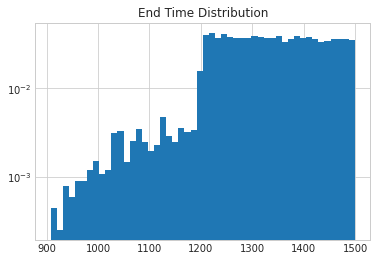

In [77]:
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [78]:
warm_up_time = exp_stats_info["warmup_time"]
estimated_end_time = exp_stats_info["warmup_time"] + exp_stats_info["run_time"]

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 2194 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [79]:
collision_df.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
7,ITE_autoware_universe_map_recalibrate_v5_335_8,1281.4,1125,300,BV_14.19,BV_17.76,3.250293,650,BV_14.19,0.6,LeftFoll,highway_cutin,29052.882386,1109.840861,EG_1_3_1_1,sideswipe,freeway_1,18.6095436533451,-0.401694,2.326511
10,ITE_autoware_universe_map_recalibrate_v5_335_11,1119.4,1004,300,BV_2.32,BV_23.28,3.244388,635,BV_23.28,2.1,Lead,intersection_rearend,26647.170131,1391.237132,:NODE_25_1_0,rear_end,intersection,3.1149254928001398,3.280000,5.827738
15,ITE_autoware_universe_map_recalibrate_v5_335_16,1298.3,1097,300,BV_2.34,BV_18.17,2.774857,480,BV_2.34,0.6,LeftFoll,intersection_cutin,38294.402857,2605.300869,EG_18_12_171_1,sideswipe,intersection,15.739036176135414,-1.812983,0.625831
20,ITE_autoware_universe_map_recalibrate_v5_335_21,1086.7,973,300,BV_23.24,BV_2.31,3.257770,175,BV_2.31,2.1,Lead,intersection_rearend,20760.786968,1036.689688,EG_25_2_1_0,rear_end,intersection,0.0,-0.579813,5.886139


In [80]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - exp_stats_info["warmup_time"]).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 20407
Number of collision: 2194
Collisions with weight less than 1: 2027
Importance summation: 2.185678243438454
Max weight: 0.02141184322576485, Min weight: 1.6411005314480842e-10
raw collision rate: 0.1075121281913069
adjusted collision rate (importance): 0.00010710433887580017
Collision due to traffic light ignorance: 112
Overall maneuvers: 18136077
Collision without negligence: 181
Maximum time between collision and negligence: 4.50 s

Overall time: 5791389.80 s
Maneuvers per second: 3.1315586804397104
Overall route length: 1152255548.11 m
m/s: 198.9601093869482
Overall route length: 715978.4036914769 mile
mile/s: 0.12362808037743839 mile/s
Crash per mile: 3.052715322374846e-06 crash/mile


In [81]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v5_335_1,1458.0,1158,300,NaN,NaN,-0.131116,1256,NaN,-1.0,NaN,NaN,59742.574303,1164.317613,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v5_335_2,1356.0,1056,300,NaN,NaN,-0.135733,1422,NaN,-1.0,NaN,NaN,65263.429753,5814.373385,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
3,ITE_autoware_universe_map_recalibrate_v5_335_4,1486.0,1186,300,NaN,NaN,-0.066067,634,NaN,-1.0,NaN,NaN,55886.421775,4212.496508,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v5_335_5,1379.0,1079,300,NaN,NaN,2.140136,1446,NaN,-1.0,NaN,NaN,66085.649545,1943.239007,NaN,NaN,NaN,None,-10.000000,NaN


In [82]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < exp_stats_info["warmup_time"] + exp_stats_info["run_time"])]
a

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
349,ITE_autoware_universe_map_recalibrate_v5_278_43,983.5,901,300,BV_2.30,BV_2.31,-0.027564,201,BV_2.31,-1.0,NaN,NaN,16106.230824,467.987026,EG_18_12_171_1,angle,intersection,61.96443881897363,-0.363088,2.632856
397,ITE_autoware_universe_map_recalibrate_v5_132_9,1165.6,1060,300,BV_16.16,BV_13.16,-0.027936,250,BV_13.16,-1.0,NaN,NaN,25058.853345,452.613974,:NODE_18_10_0,angle,intersection,119.31534297202177,3.280000,5.440393
578,ITE_autoware_universe_map_recalibrate_v5_36_21,1246.5,1129,300,BV_1.14,BV_22.8,-0.025913,263,BV_22.8,-1.0,NaN,NaN,24612.888783,2549.778304,:NODE_18_8_0,angle,intersection,140.9555911476071,-1.000000,9.961578
784,ITE_autoware_universe_map_recalibrate_v5_385_27,1164.8,1087,300,BV_16.19,BV_13.10,-0.016813,133,BV_13.10,-1.0,NaN,NaN,16884.320994,376.770536,:NODE_18_10_0,head_on,intersection,120.74653932496796,3.280000,5.478251
912,ITE_autoware_universe_map_recalibrate_v5_121_26,1251.4,1007,300,BV_16.16,BV_13.6,-0.065008,832,BV_13.6,-1.0,NaN,NaN,45281.676468,1860.014790,:NODE_18_10_0,angle,intersection,119.19365404275669,3.280000,5.621647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19713,ITE_autoware_universe_map_recalibrate_v5_246_10,1102.9,1014,300,BV_5.13,BV_4.12,-0.012301,171,BV_4.12,-1.0,NaN,NaN,18139.837830,865.220186,:NODE_11_15_0,head_on,intersection,135.48959671501166,3.280000,5.593195
19911,ITE_autoware_universe_map_recalibrate_v5_474_43,1251.6,1145,300,BV_16.19,BV_13.9,-0.041180,470,BV_13.9,-1.0,NaN,NaN,24827.775879,1988.912773,:NODE_18_10_0,angle,intersection,118.99509855698955,3.280000,5.807198
19982,ITE_autoware_universe_map_recalibrate_v5_429_24,1160.3,1097,300,BV_2.23,BV_2.24,-0.023883,27,BV_2.24,-1.0,NaN,NaN,10484.268787,1012.490542,EG_18_12_171_1,rear_end,intersection,56.81217030207779,-0.226449,2.805376
20083,ITE_autoware_universe_map_recalibrate_v5_479_3,1423.0,1138,300,BV_16.16,BV_7.10,-0.106446,1112,BV_7.10,-1.0,NaN,NaN,58782.514907,1410.630215,:NODE_18_10_0,head_on,intersection,121.03110378990363,3.280000,4.240159


#### BV_22 Collision

In [83]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 204
Total bv_22 distance: 58504350.36977424
Number of bv_22 collision importance > 1: 11
Raw collision rate: 0.009996569804478855
Collision rate: 1.0736787777238615e-05
Collision rate (weighted): 6.027181326398782e-06


### Crash Distribution (with negligence)

In [84]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [85]:
exp_stats_info.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v5_335_1,1458.0,1158,300,NaN,NaN,-0.131116,1256,NaN,-1.0,NaN,NaN,59742.574303,1164.317613,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v5_335_2,1356.0,1056,300,NaN,NaN,-0.135733,1422,NaN,-1.0,NaN,NaN,65263.429753,5814.373385,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
3,ITE_autoware_universe_map_recalibrate_v5_335_4,1486.0,1186,300,NaN,NaN,-0.066067,634,NaN,-1.0,NaN,NaN,55886.421775,4212.496508,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v5_335_5,1379.0,1079,300,NaN,NaN,2.140136,1446,NaN,-1.0,NaN,NaN,66085.649545,1943.239007,NaN,NaN,NaN,None,-10.000000,NaN


In [86]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

2014 181


Negligence caused distribution

In [87]:
neg_caused_collision["lane_id"].value_counts()

EG_25_2_1_0       216
EG_1_3_1_1        149
EG_16_23_1_1      140
EG_1_3_1_0        113
EG_17_1_1_0       109
                 ... 
:NODE_17_11_0       1
EG_7_4_1_0          1
:nd_34_1_6_0_1      1
:NODE_11_11_0       1
:nd_15_1_3_0_0      1
Name: lane_id, Length: 111, dtype: int64

No negligence caused distribution

In [88]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

:NODE_18_10_0     121
:nd_34_1_6_0_0     13
:nd_34_1_6_1_0     10
EG_18_12_171_1      9
:NODE_18_8_0        8
:NODE_11_15_0       7
EG_16_45_1_1        7
EG_18_12_171_0      3
:NODE_18_17_0       2
:NODE_6_2_0         1
Name: lane_id, dtype: int64
181


### Crash Distribution (with negligence)

In [89]:
neg_caused_collision.head()

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
7,ITE_autoware_universe_map_recalibrate_v5_335_8,1281.4,1125,300,BV_14.19,BV_17.76,3.250293,650,BV_14.19,0.6,LeftFoll,highway_cutin,29052.882386,1109.840861,EG_1_3_1_1,sideswipe,freeway_1,18.6095436533451,-0.401694,2.326511
10,ITE_autoware_universe_map_recalibrate_v5_335_11,1119.4,1004,300,BV_2.32,BV_23.28,3.244388,635,BV_23.28,2.1,Lead,intersection_rearend,26647.170131,1391.237132,:NODE_25_1_0,rear_end,intersection,3.1149254928001398,3.280000,5.827738
15,ITE_autoware_universe_map_recalibrate_v5_335_16,1298.3,1097,300,BV_2.34,BV_18.17,2.774857,480,BV_2.34,0.6,LeftFoll,intersection_cutin,38294.402857,2605.300869,EG_18_12_171_1,sideswipe,intersection,15.739036176135414,-1.812983,0.625831
20,ITE_autoware_universe_map_recalibrate_v5_335_21,1086.7,973,300,BV_23.24,BV_2.31,3.257770,175,BV_2.31,2.1,Lead,intersection_rearend,20760.786968,1036.689688,EG_25_2_1_0,rear_end,intersection,0.0,-0.579813,5.886139


In [90]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [91]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_366256/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,12,0.008537,0.000588,4.183426e-07
1,freeway,rear,44,0.360657,0.002156,1.767320e-05
2,freeway,sideswipe,268,0.141388,0.013133,6.928430e-06
3,intersection,angle,229,0.608683,0.011222,2.982718e-05
4,intersection,head,80,0.063498,0.003920,3.111572e-06
5,intersection,rear,1005,0.568266,0.049248,2.784660e-05
6,intersection,sideswipe,197,0.318694,0.009654,1.561690e-05
7,roundabout,angle,107,0.057128,0.005243,2.799430e-06
8,roundabout,rear,36,0.025958,0.001764,1.271994e-06
9,roundabout,sideswipe,36,0.019157,0.001764,9.387492e-07


location
freeway         0.233604
intersection    0.713344
roundabout      0.046778
Name: exp_importance, dtype: float64


Text(0.5, 1.0, 'ground truth')

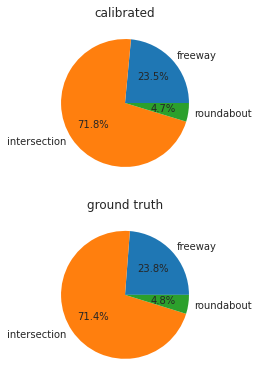

In [92]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

In [93]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

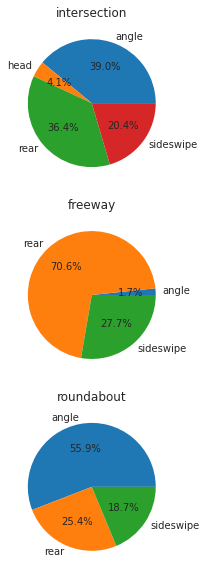

In [94]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [95]:
len(neg_caused_collision)

2014

#### Negligence reason

In [96]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,42,0.359480,0.002058,0.000018
1,freeway,LeftFoll,151,0.083169,0.007399,0.000004
2,freeway,RightFoll,131,0.067934,0.006419,0.000003
3,intersection,Lead,1102,0.587145,0.054001,0.000029
4,intersection,LeftFoll,211,0.334524,0.010340,0.000016
5,intersection,RightFoll,86,0.136003,0.004214,0.000007
6,intersection,TFL,112,0.501468,0.005488,0.000025
7,roundabout,Lead,41,0.028160,0.002009,0.000001
8,roundabout,LeftFoll,59,0.032786,0.002891,0.000002
9,roundabout,RightFoll,79,0.041296,0.003871,0.000002


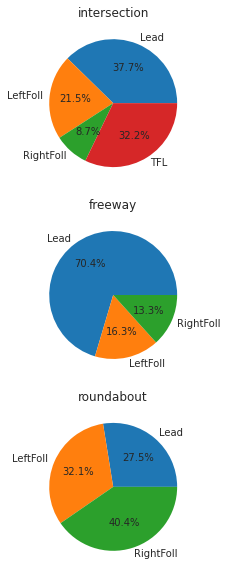

In [97]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [98]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,2,0.002770,0.000098,1.357515e-07
1,freeway,rear,1,0.008628,0.000049,4.228091e-07
2,freeway,sideswipe,24,0.013294,0.001176,6.514601e-07
3,intersection,angle,17,0.052046,0.000833,2.550396e-06
4,intersection,rear,73,0.040486,0.003577,1.983907e-06
5,intersection,sideswipe,56,0.091313,0.002744,4.474590e-06
6,roundabout,angle,10,0.005609,0.000490,2.748470e-07
7,roundabout,rear,7,0.003285,0.000343,1.609558e-07
8,roundabout,sideswipe,1,0.000546,0.000049,2.673518e-08


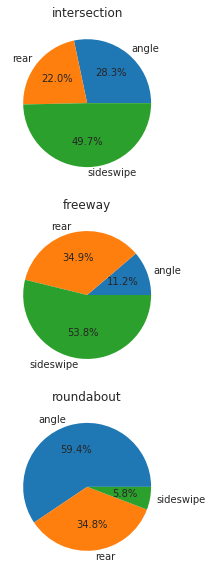

In [99]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [100]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

280


In [101]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,...,lane_id,collision_type,location_type,relative_heading,distance,collision_severity,exp_importance,location,collision,exp_cum
13049,ITE_autoware_universe_map_recalibrate_v5_345_8,1344.6,1052,300,BV_17.60,BV_17.61,3.166311,1024,BV_17.60,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.486378152722125,-0.375059,3.028159,6.818501e-04,freeway,sideswipe,0.004548
19245,ITE_autoware_universe_map_recalibrate_v5_423_12,1280.5,1156,300,BV_21.56,BV_17.65,3.281127,317,BV_21.56,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.64106627243899,-0.204138,3.989272,5.234469e-04,freeway,sideswipe,0.008039
4778,ITE_autoware_universe_map_recalibrate_v5_139_10,1127.6,1038,300,BV_21.61,BV_17.44,3.264890,491,BV_21.61,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,16.785381925707867,-0.712618,3.617522,5.433880e-04,freeway,sideswipe,0.011664
3933,ITE_autoware_universe_map_recalibrate_v5_314_27,1222.3,1167,300,BV_21.57,BV_17.56,3.255703,466,BV_21.57,0.6,...,EG_1_1_1_0,sideswipe,freeway_2,16.8951375066261,-1.365942,2.794121,5.550056e-04,freeway,sideswipe,0.015366
17750,ITE_autoware_universe_map_recalibrate_v5_20_3,1140.1,1092,300,BV_8.58,BV_17.54,3.291802,71,BV_8.58,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,16.911670650701694,-0.522699,3.180159,5.107379e-04,freeway,sideswipe,0.018772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10705,ITE_autoware_universe_map_recalibrate_v5_404_36,1240.9,1049,300,BV_21.61,BV_8.62,6.492050,793,BV_21.61,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.543173277506483,-0.972548,2.405557,3.220695e-07,freeway,sideswipe,0.902115
15018,ITE_autoware_universe_map_recalibrate_v5_362_3,1343.9,1189,300,BV_21.68,BV_17.62,3.258685,389,BV_21.68,0.6,...,EG_1_3_1_0,sideswipe,freeway_1,19.649394603737306,-1.581783,2.081944,5.512075e-04,freeway,sideswipe,0.905792
11871,ITE_autoware_universe_map_recalibrate_v5_376_2,1299.2,1079,300,BV_8.62,BV_21.66,3.229291,656,BV_8.62,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.651802455061727,-0.303103,1.895201,5.898058e-04,freeway,sideswipe,0.909726
18597,ITE_autoware_universe_map_recalibrate_v5_143_13,1033.3,1025,300,BV_14.15,BV_21.35,3.298176,29,BV_14.15,0.6,...,EG_1_3_1_1,sideswipe,freeway_1,19.67747772170003,-0.372676,1.896789,5.032969e-04,freeway,sideswipe,0.913083


0.04285714285714286


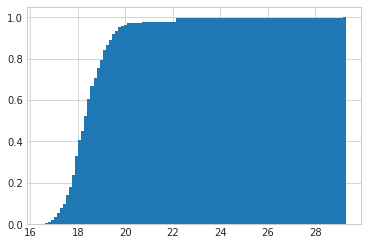

In [102]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

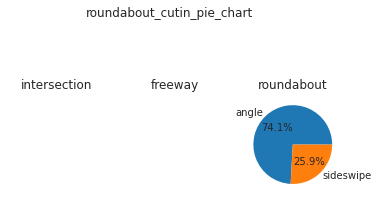

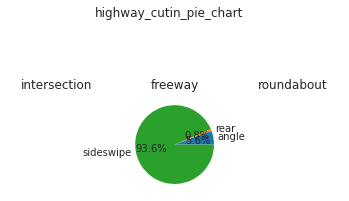

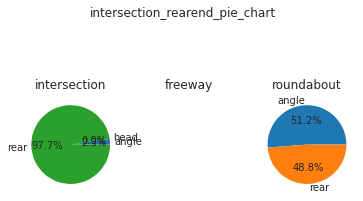

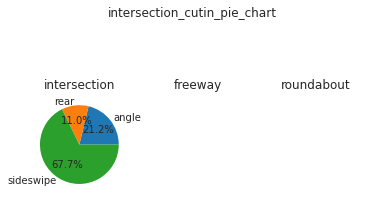

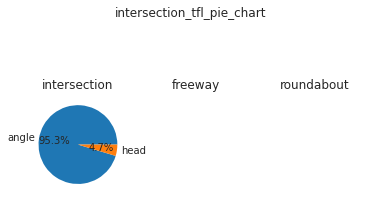

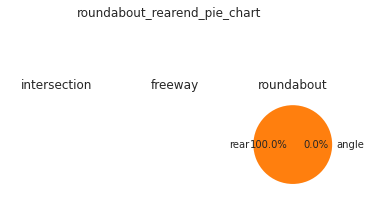

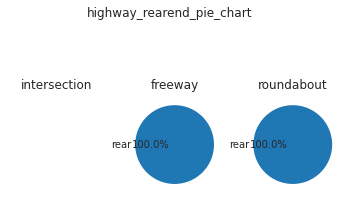

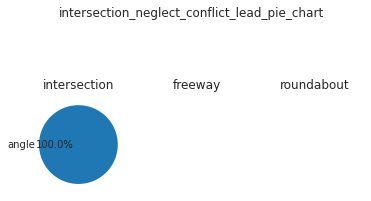

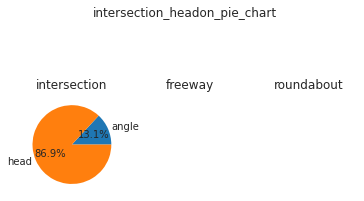

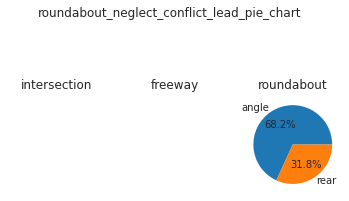

In [103]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [104]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

roundabout_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,102,0.054925,0.004998,2.691494e-06
1,roundabout,sideswipe,36,0.019157,0.001764,9.387492e-07


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,angle,12,0.008537,0.000588,4.183426e-07
1,freeway,rear,2,0.001177,0.000098,5.769318e-08
2,freeway,sideswipe,268,0.141388,0.013133,6.928430e-06


intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,22,1.215448e-02,0.001078,5.956033e-07
1,intersection,head,1,2.646780e-07,0.000049,1.296996e-11
2,intersection,rear,972,5.163611e-01,0.047631,2.530313e-05
3,roundabout,angle,2,1.094489e-03,0.000098,5.363302e-08
4,roundabout,rear,2,1.041569e-03,0.000098,5.103981e-08


intersection_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,67,0.099929,0.003283,0.000005
1,intersection,rear,33,0.051905,0.001617,0.000003
2,intersection,sideswipe,197,0.318694,0.009654,0.000016


intersection_tfl


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,95,0.472142,0.004655,0.000023
1,intersection,head,5,0.023028,0.000245,0.000001


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,1,3.053942e-07,0.000049,1.496517e-11
1,roundabout,rear,32,1.658979e-02,0.001568,8.129459e-07


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,42,0.359480,0.002058,1.761551e-05
1,roundabout,rear,1,0.007809,0.000049,3.826450e-07


intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,33,0.018355,0.001617,8.994281e-07


intersection_headon


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,12,0.006104,0.000588,2.990952e-07
1,intersection,head,74,0.040469,0.003626,1.983113e-06


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,2,0.001108,0.000098,5.428828e-08
1,roundabout,rear,1,0.000518,0.000049,2.536342e-08


In [105]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

Defaulting to user installation because normal site-packages is not writeable


In [106]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [107]:
A

array([[ 4896,   899,   595, 23136,   299,     0,     0,     0,     0,
            0],
       [    0,     0,     0,  1128,  1983,     0,     0,     0,     0,
            0],
       [ 2543,     0, 25303,     0,     0,     0,     0,     0,     0,
            0],
       [15616,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,  2691,    54,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,    25,   812,     0,
            0],
       [    0,     0,     0,     0,     0,   938,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,    57,
        17615],
       [    0,     0,     0,     0,     0,     0,     0,     0,  6928,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,   418,
            0]])

#### Calibration

In [108]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 36 physical cores, 36 logical processors, using up to 32 threads

Optimize a model with 40 rows, 22 columns and 98 nonzeros
Model fingerprint: 0xaa4c2311
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve time: 0.01s
Presolved: 40 rows, 22 columns, 98 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   1.000000e+31   2.000000e+02      0s
      17    7.0969130e+02   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.096913013e+02
 
***** Solution:
x =
('intersection_cutin', 0.8494890722875547)
('intersection_neglect_conflict_lead', 0.8494890722875548)
('intersecti

### Quick check

In [109]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                                 
               nunique                                            first
lane_id                                                                
:NODE_18_10_0      121   ITE_autoware_universe_map_recalibrate_v5_132_9
:nd_34_1_6_0_0      13  ITE_autoware_universe_map_recalibrate_v5_132_12
:nd_34_1_6_1_0      10   ITE_autoware_universe_map_recalibrate_v5_92_22
EG_18_12_171_1       9  ITE_autoware_universe_map_recalibrate_v5_278_43
:NODE_18_8_0         8   ITE_autoware_universe_map_recalibrate_v5_36_21
:NODE_11_15_0        7   ITE_autoware_universe_map_recalibrate_v5_97_24
EG_16_45_1_1         7   ITE_autoware_universe_map_recalibrate_v5_477_6
EG_18_12_171_0       3   ITE_autoware_universe_map_recalibrate_v5_64_25
:NODE_18_17_0        2  ITE_autoware_universe_map_recalibrate_v5_276_24
:NODE_6_2_0          1  ITE_autoware_universe_map_recalibrate_v5_368_33

0.02141184322576485 1.6411005314480842e-10


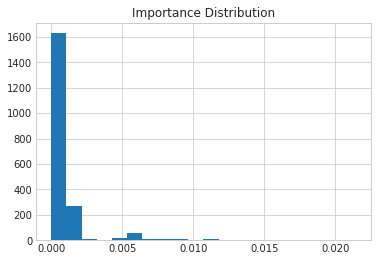

In [110]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [111]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [112]:
# ! pip install shapely

In [113]:
exp_stats_info

,name,end_time,warmup_time,run_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,collision_severity
0,ITE_autoware_universe_map_recalibrate_v5_335_1,1458.0,1158,300,NaN,NaN,-0.131116,1256,NaN,-1.0,NaN,NaN,59742.574303,1164.317613,NaN,NaN,NaN,None,-10.000000,NaN
1,ITE_autoware_universe_map_recalibrate_v5_335_2,1356.0,1056,300,NaN,NaN,-0.135733,1422,NaN,-1.0,NaN,NaN,65263.429753,5814.373385,NaN,NaN,NaN,None,-10.000000,NaN
2,ITE_autoware_universe_map_recalibrate_v5_335_3,1141.7,953,300,BV_8.64,BV_21.50,3.223361,1074,BV_8.64,0.7,LeftFoll,roundabout_cutin,37992.065602,2561.285322,:NODE_5_1_1,angle,roundabout,45.41413316006066,-1.379763,4.064855
3,ITE_autoware_universe_map_recalibrate_v5_335_4,1486.0,1186,300,NaN,NaN,-0.066067,634,NaN,-1.0,NaN,NaN,55886.421775,4212.496508,NaN,NaN,NaN,None,-10.000000,NaN
4,ITE_autoware_universe_map_recalibrate_v5_335_5,1379.0,1079,300,NaN,NaN,2.140136,1446,NaN,-1.0,NaN,NaN,66085.649545,1943.239007,NaN,NaN,NaN,None,-10.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20402,ITE_autoware_universe_map_recalibrate_v5_57_36,1266.0,966,300,NaN,NaN,-0.107005,1153,NaN,-1.0,NaN,NaN,73886.172117,3801.888533,NaN,NaN,NaN,None,-10.000000,NaN
20403,ITE_autoware_universe_map_recalibrate_v5_57_37,1445.0,1145,300,NaN,NaN,2.730323,1016,NaN,-1.0,NaN,NaN,61671.432403,3162.728515,NaN,NaN,NaN,None,-10.000000,NaN
20404,ITE_autoware_universe_map_recalibrate_v5_57_38,1085.5,1050,300,BV_23.22,BV_2.33,3.287632,145,BV_2.33,2.1,Lead,intersection_rearend,7318.093798,101.200966,EG_25_2_1_0,rear_end,intersection,1.4210854715202004e-14,-0.528086,5.934875
20405,ITE_autoware_universe_map_recalibrate_v5_57_39,1237.0,937,300,NaN,NaN,-0.080216,677,NaN,-1.0,NaN,NaN,57778.841928,3024.214820,NaN,NaN,NaN,None,-10.000000,NaN


### Generate videos in the check list

In [114]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [115]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

In [116]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

  0%|          | 0/181 [00:01<?, ?it/s]

/gpfs/accounts/henryliu_root/henryliu98/shared_data/safetest-nade/ITE_autoware_universe_map_recalibrate_v5/raw_data/final_state/ITE_autoware_universe_map_recalibrate_v5_204_final_state.json


FileNotFoundError: [Errno 2] No such file or directory: './maps/Mcity/mcity.net.xml'

### See README-viz.md for visualization

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

In [ ]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()